Start by importing necessary libraries

In [319]:
# First, we need to install the necessary libraries
!pip install pandas requests mpl_toolkfits chembl_webresource_client rdkit seaborn padelpy lazypredict

ERROR: Could not find a version that satisfies the requirement mpl_toolkfits (from versions: none)
ERROR: No matching distribution found for mpl_toolkfits


In [142]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import padelpy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyRegressor
import numpy as np
import seaborn as sns

In [143]:
# Here, we assign the font type and size for the matplot interfaces
plt.rcParams["font.family"] = "Garamond"
plt.rcParams.update({'font.size': 16})

In [144]:
# This searches for targets
target = new_client.target
target_query = target.search('CHEMBL3927')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,17.00,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859


We will be using the chlorquine resistance transporter at index [0] of score 33.0 (which is the highest score)

# Search for target protein on ChEMBL

In [145]:
targets.to_csv('chloroquine_protein_data_from_ChEMBL.csv', index=False)

# Select the entry index here below

In [146]:
# Select and retrieve bioactivity data for chloroquine resistance protein (first entry) 
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL3927'

In [147]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

Data Preprocessing and Descriptive Statistic Analysis

In [148]:
# Convert to dataframe
df = pd.DataFrame(res)

In [149]:
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,None,12041507,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.6
129,None,12041508,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.1
130,None,12041509,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,11.5
131,None,12041510,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.7


In [150]:
df.to_csv('dataframe_for_selected_protein.csv', index=False)

In [151]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,None,12041507,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.6
129,None,12041508,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.1
130,None,12041509,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,11.5
131,None,12041510,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.7


In [152]:
len(df2.canonical_smiles.unique())

86

In [153]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,BAO_0000357,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,None,12040781,[],CHEMBL2149727,Inhibition of SARS-CoV 3CLpro expressed in Esc...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,21.1
110,None,12040782,[],CHEMBL2149727,Inhibition of SARS-CoV 3CLpro expressed in Esc...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,226.7
111,None,12040783,[],CHEMBL2149727,Inhibition of SARS-CoV 3CLpro expressed in Esc...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,38.7
112,None,12040784,[],CHEMBL2149727,Inhibition of SARS-CoV 3CLpro expressed in Esc...,B,None,None,BAO_0000190,BAO_0000019,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,14.4


In [154]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0
...,...,...,...
109,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.0
110,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.0
111,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.0
112,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.0


In [155]:
df3.to_csv('2-raw_data.csv', index=False)

In [156]:
df4 = pd.read_csv('2-raw_data.csv')

In [157]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 15000:
    bioactivity_threshold.append("inactive")
  #elif float(i) <= 1000:
    #bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("active")

In [158]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.00,active
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.00,active
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.00,active
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.00,active
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.00,active
...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.00,inactive
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.00,inactive
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.00,inactive
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.00,active


In [159]:
df5.to_csv('3-raw_data.csv', index=False)

In [71]:
! zip project_preparatory_stage.zip *.csv

  adding: 0-raw_data.csv (deflated 94%)



  adding: 1-raw_data.csv (deflated 91%)



  adding: 2-raw_data.csv (deflated 81%)



  adding: 3-raw_data.csv (deflated 82%)


In [160]:
df = pd.read_csv('3-raw_data.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.00,active
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.00,active
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.00,active
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.00,active
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.00,active
...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.00,inactive
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.00,inactive
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.00,inactive
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.00,active


In [161]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [162]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [163]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL187579,7200.00,active,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21
1,CHEMBL188487,9400.00,active,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21
2,CHEMBL185698,13500.00,active,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21
3,CHEMBL426082,13110.00,active,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21
4,CHEMBL187717,2000.00,active,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-]
...,...,...,...,...
81,CHEMBL2146517,21100.00,inactive,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...
82,CHEMBL187460,226700.00,inactive,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C
83,CHEMBL363535,38700.00,inactive,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12
84,CHEMBL227075,14400.00,active,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1


calculating Lipinski descriptors

In [164]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i+= 1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [165]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.27,1.89,0.00,5.00
1,415.59,3.81,0.00,2.00
2,421.19,2.66,0.00,4.00
3,293.35,3.63,0.00,3.00
4,338.34,3.54,0.00,5.00
...,...,...,...,...
81,338.36,3.40,0.00,5.00
82,296.37,3.44,0.00,3.00
83,276.29,4.10,0.00,3.00
84,278.31,3.29,0.00,3.00


In [166]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.00,active
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.00,active
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.00,active
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.00,active
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.00,active
...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.00,inactive
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.00,inactive
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.00,inactive
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.00,active


In [167]:
# Concatenating df and df_lipinski
df_combined = pd.concat([df,df_lipinski], axis=1)

In [168]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.00,active,281.27,1.89,0.00,5.00
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.00,active,415.59,3.81,0.00,2.00
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.00,active,421.19,2.66,0.00,4.00
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.00,active,293.35,3.63,0.00,3.00
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.00,active,338.34,3.54,0.00,5.00
...,...,...,...,...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,21100.00,inactive,338.36,3.40,0.00,5.00
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,226700.00,inactive,296.37,3.44,0.00,3.00
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,38700.00,inactive,276.29,4.10,0.00,3.00
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,14400.00,active,278.31,3.29,0.00,3.00


In [169]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [170]:
df_combined.standard_value.describe()

count        86.00
mean      71384.05
std      144115.58
min          50.00
25%        9550.00
50%       16000.00
75%       48927.21
max     1000000.00
Name: standard_value, dtype: float64

In [171]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [172]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,active,281.27,1.89,0.00,5.00,7200.00
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,active,415.59,3.81,0.00,2.00,9400.00
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,active,421.19,2.66,0.00,4.00,13500.00
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,active,293.35,3.63,0.00,3.00,13110.00
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],active,338.34,3.54,0.00,5.00,2000.00
...,...,...,...,...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.36,3.40,0.00,5.00,21100.00
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.37,3.44,0.00,3.00,226700.00
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.29,4.10,0.00,3.00,38700.00
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,active,278.31,3.29,0.00,3.00,14400.00


In [173]:
df_norm.standard_value_norm.describe()

count        86.00
mean      71384.05
std      144115.58
min          50.00
25%        9550.00
50%       16000.00
75%       48927.21
max     1000000.00
Name: standard_value_norm, dtype: float64

In [174]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,active,281.27,1.89,0.00,5.00,5.14
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,active,415.59,3.81,0.00,2.00,5.03
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,active,421.19,2.66,0.00,4.00,4.87
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,active,293.35,3.63,0.00,3.00,4.88
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],active,338.34,3.54,0.00,5.00,5.70
...,...,...,...,...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.36,3.40,0.00,5.00,4.68
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.37,3.44,0.00,3.00,3.64
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.29,4.10,0.00,3.00,4.41
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,active,278.31,3.29,0.00,3.00,4.84


In [176]:
df_final.pIC50.describe()

count   86.00
mean     4.85
std      0.97
min      3.00
25%      4.31
50%      4.80
75%      5.02
max      7.30
Name: pIC50, dtype: float64

In [177]:
df_final.to_csv('4-processed_data.csv')

Lets remove the intermediate class from the dataset

In [178]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,active,281.27,1.89,0.00,5.00,5.14
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,active,415.59,3.81,0.00,2.00,5.03
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,active,421.19,2.66,0.00,4.00,4.87
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,active,293.35,3.63,0.00,3.00,4.88
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],active,338.34,3.54,0.00,5.00,5.70
...,...,...,...,...,...,...,...,...
81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.36,3.40,0.00,5.00,4.68
82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.37,3.44,0.00,3.00,3.64
83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.29,4.10,0.00,3.00,4.41
84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,active,278.31,3.29,0.00,3.00,4.84


In [179]:
df_2class.to_csv('5-processed_data.csv')

# Exploratory Data Analysis

In [180]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

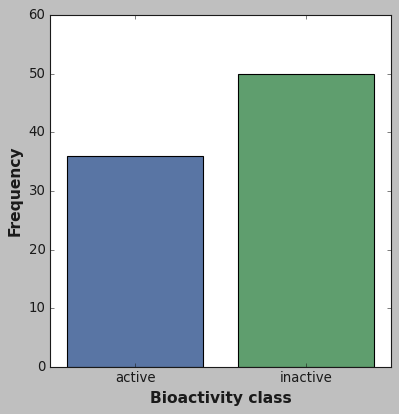

In [183]:
plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.ylim([0,60])
plt.savefig('plot_bioactivity_class.svg')

Scatter plot of MW versus LogP <br>
It can be seen that the 2 bioactivity classes are spanning similar <br> chemical spaces as evident by the scatter plot of ```MW``` vs ```LogP```.

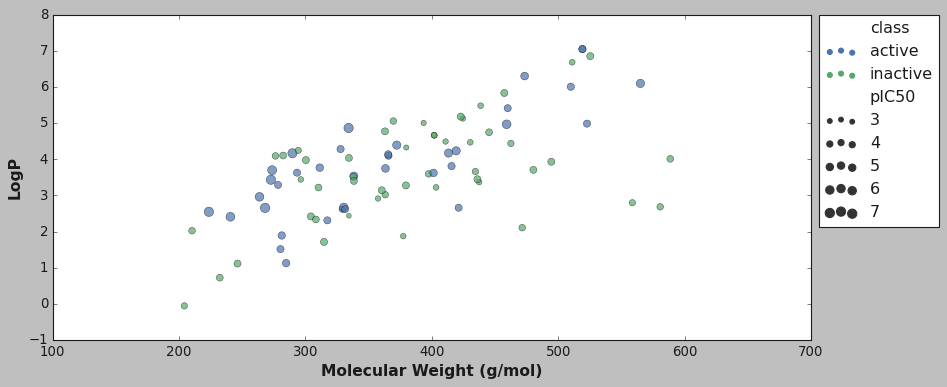

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
plt.figure(figsize=(12, 5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('Molecular Weight (g/mol)', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig('plot_MW_vs_LogP.svg')

Box-plots of pIC50 value against Bioactivity class

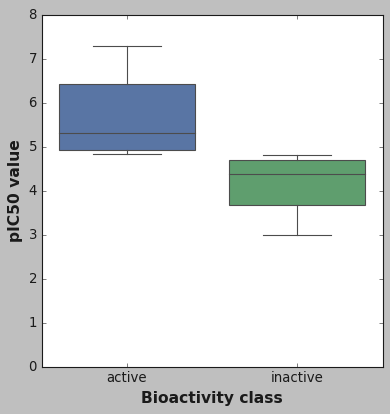

In [187]:
plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
plt.ylim([0,8])
plt.savefig('plot_ic50.svg')

Statistical analysis | Mann-Whitney U Test

In [188]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [189]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1800.00,0.00,0.05,Different distribution (reject H0)


Molecular Weight

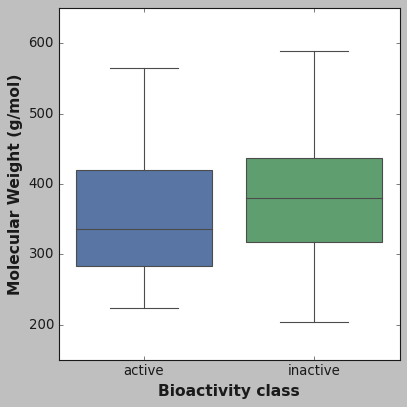

In [191]:
plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Molecular Weight (g/mol)', fontsize=14, fontweight='bold')
plt.ylim([150,650])
plt.savefig('plot_MW.svg')

In [192]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,752.00,0.20,0.05,Same distribution (fail to reject H0)


LogP

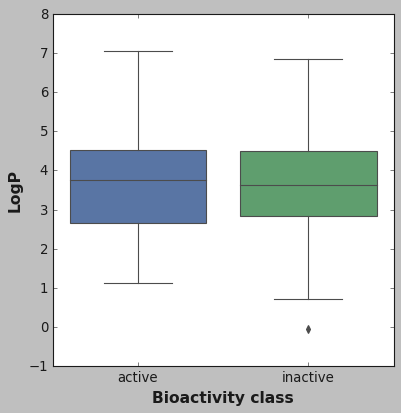

In [193]:
plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.svg')

In [194]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,963.00,0.58,0.05,Same distribution (fail to reject H0)


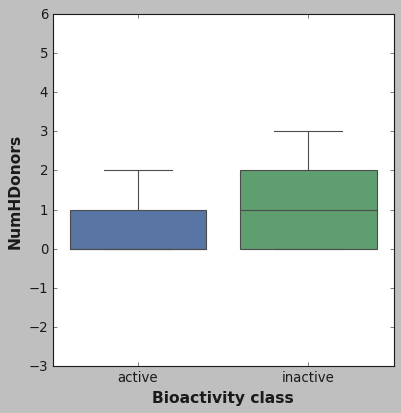

In [195]:
plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.ylim([-3, 6])

plt.savefig('plot_NumHDonors.svg')

In [196]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,473.50,0.00,0.05,Different distribution (reject H0)


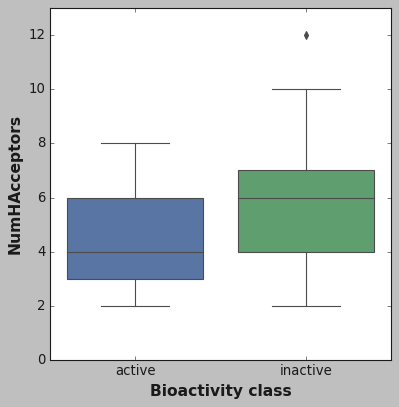

In [198]:
plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')
plt.ylim([0,13])
plt.savefig('plot_NumHAcceptors.svg')

In [199]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,655.50,0.03,0.05,Different distribution (reject H0)


# Descriptors Calculations

In [200]:
df3 = pd.read_csv('5-processed_data.csv')

In [201]:
df3

,Unnamed: 0,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,active,281.27,1.89,0.00,5.00,5.14
1,1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,active,415.59,3.81,0.00,2.00,5.03
2,2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,active,421.19,2.66,0.00,4.00,4.87
3,3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,active,293.35,3.63,0.00,3.00,4.88
4,4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],active,338.34,3.54,0.00,5.00,5.70
...,...,...,...,...,...,...,...,...,...
81,81,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.36,3.40,0.00,5.00,4.68
82,82,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.37,3.44,0.00,3.00,3.64
83,83,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.29,4.10,0.00,3.00,4.41
84,84,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,active,278.31,3.29,0.00,3.00,4.84


In [202]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [71]:
! cat molecule.smi | head -5

CN(Cc1ccccc1)Cc1ccccc1CNc1ccnc2cc(Cl)ccc12	CHEMBL1830985
CN(Cc1ccccc1)Cc1cccc(CNc2ccnc3cc(Cl)ccc23)c1	CHEMBL1830986
CN(Cc1ccccc1)Cc1ccc(CNc2ccnc3cc(Cl)ccc23)cc1	CHEMBL1830987
CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1	CHEMBL114
Clc1cccc(C(Nc2ccnc3cc(Cl)ccc23)c2ccc(CN3CCNCC3)cc2)c1	CHEMBL2170036


In [72]:
! cat molecule.smi | wc -l

19


# Calculate fingerprint descriptors using PaDEL descriptors

In [73]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2023-04-01 01:54:44--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2023-04-01 01:54:45--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  --.-KB/s    in 0.1s    

2023-04-01 01:54:46 (172 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2023-04-01 01:54:47--  https://gi

In [74]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [203]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [204]:
! bash padel.sh

Processing CHEMBL187579 in molecule.smi (1/86). 
Processing CHEMBL426082 in molecule.smi (4/86). 
Processing CHEMBL185698 in molecule.smi (3/86). 
Processing CHEMBL188487 in molecule.smi (2/86). 
Processing CHEMBL187717 in molecule.smi (5/86). Average speed: 1.96 s/mol.
Processing CHEMBL365134 in molecule.smi (6/86). Average speed: 1.01 s/mol.
Processing CHEMBL190743 in molecule.smi (8/86). Average speed: 0.59 s/mol.
Processing CHEMBL187598 in molecule.smi (7/86). Average speed: 0.72 s/mol.
Processing CHEMBL365469 in molecule.smi (9/86). Average speed: 0.56 s/mol.
Processing CHEMBL188983 in molecule.smi (10/86). Average speed: 0.48 s/mol.
Processing CHEMBL370923 in molecule.smi (12/86). Average speed: 0.39 s/mol.
Processing CHEMBL191575 in molecule.smi (11/86). Average speed: 0.43 s/mol.
Processing CHEMBL194398 in molecule.smi (13/86). Average speed: 0.40 s/mol.
Processing CHEMBL196635 in molecule.smi (14/86). Average speed: 0.37 s/mol.
Processing CHEMBL358279 in molecule.smi (16/86). 

In [77]:
! ls -l

total 26580
-rw-r--r-- 1 root root     1390 Apr  1 01:38 2-raw_data.csv
-rw-r--r-- 1 root root     1559 Apr  1 01:40 3-raw_data.csv
-rw-r--r-- 1 root root     2593 Apr  1 01:43 4-processed_data.csv
-rw-r--r-- 1 root root     2593 Apr  1 01:43 5-processed_data.csv
drwxrwxr-x 4 root root     4096 May 30  2020 PaDEL-Descriptor
drwxr-xr-x 3 root root     4096 Apr  1 01:54 __MACOSX
---------- 1 root root      263 Apr  1 01:16 __notebook_source__.ipynb
-rw-r--r-- 1 root root  1087658 Apr  1 01:32 chloroquine_protein_data_from_ChEMBL.csv
-rw-r--r-- 1 root root    15565 Apr  1 01:36 dataframe_for_selected_protein.csv
-rw-r--r-- 1 root root    45111 Apr  1 01:55 descriptors_output.csv
-rw-r--r-- 1 root root      119 Apr  1 01:45 mannwhitneyu_LogP.csv
-rw-r--r-- 1 root root      117 Apr  1 01:45 mannwhitneyu_MW.csv
-rw-r--r-- 1 root root      127 Apr  1 01:46 mannwhitneyu_NumHAcceptors.csv
-rw-r--r-- 1 root root      125 Apr  1 01:46 mannwhitneyu_NumHDonors.csv
-rw-r--r-- 1 root root      121 Ap

# Preparing X and Y Data Matrices

In [205]:
df3_X = pd.read_csv('descriptors_output.csv')

In [206]:
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL187579,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL188487,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL185698,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL426082,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL365134,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,CHEMBL187460,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82,CHEMBL2146517,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,CHEMBL227075,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,CHEMBL363535,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [207]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
82,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
83,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Y variable [convert IC50 to pIC50]

In [208]:
df3_Y = df3['pIC50']
df3_Y

0    5.14
1    5.03
2    4.87
3    4.88
4    5.70
     ... 
81   4.68
82   3.64
83   4.41
84   4.84
85   4.68
Name: pIC50, Length: 86, dtype: float64

In [209]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.14
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.03
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.87
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.88
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.68
82,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.64
83,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.41
84,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.84


In [210]:
dataset3.to_csv('6-described_data.csv', index=False)

# Building a regression model with random forest to predict pIC50 values

In [211]:
df = pd.read_csv('6-described_data.csv')

In [212]:
import numpy as np

def clean_dataset(data):
    """
    Remove inputs that contain NaN, infinity or large values for type('float64') in a dataset.

    Args:
    data (numpy array): dataset to be cleaned

    Returns:
    numpy array: cleaned dataset
    """
    mask = np.isnan(data) | np.isinf(data) | (np.abs(data) > np.finfo(np.float64).max)
    data_cleaned = data[~mask.any(axis=1)]
    return data_cleaned


In [213]:
import numpy as np

# generate a sample dataset with NaN, inf and large values
data = df

# clean the dataset
data_cleaned = clean_dataset(data)

print(data_cleaned)

    PubchemFP0  PubchemFP1  PubchemFP2  PubchemFP3  PubchemFP4  PubchemFP5  \
0            1           1           0           0           0           0   
1            1           1           0           0           0           0   
2            1           1           0           0           0           0   
3            1           1           0           0           0           0   
4            1           1           0           0           0           0   
..         ...         ...         ...         ...         ...         ...   
81           1           1           1           0           0           0   
82           1           1           1           0           0           0   
83           1           1           0           0           0           0   
84           1           1           0           0           0           0   
85           1           1           1           0           0           0   

    PubchemFP6  PubchemFP7  PubchemFP8  PubchemFP9  ...  Pubche

In [214]:
df = data_cleaned

In [215]:
# Input features
X = df.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
82,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
83,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [216]:
# Output features
Y = df.pIC50
Y

0    5.14
1    5.03
2    4.87
3    4.88
4    5.70
     ... 
81   4.68
82   3.64
83   4.41
84   4.84
85   4.68
Name: pIC50, Length: 86, dtype: float64

In [90]:
# Lets check out the dimensional shape
X.shape

(19, 881)

In [91]:
Y.shape

(19,)

In [217]:
# Lets remove low variance features
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [218]:
# Lets check out the dimensional shape again
X.shape

(86, 185)

In [219]:
Y.shape

(86,)

Training the model

In [280]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [225]:
# Lets checkout the dimensional shape after split
X_train.shape, Y_train.shape

((68, 185), (68,))

In [97]:
X_test.shape, Y_test.shape

((4, 91), (4,))

In [284]:
# Lets build a regression model using Random Forest
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.8500839932507293

In [285]:
Y_pred = model.predict(X_test)

# Scatter plot of Predicted model vs actual activity values

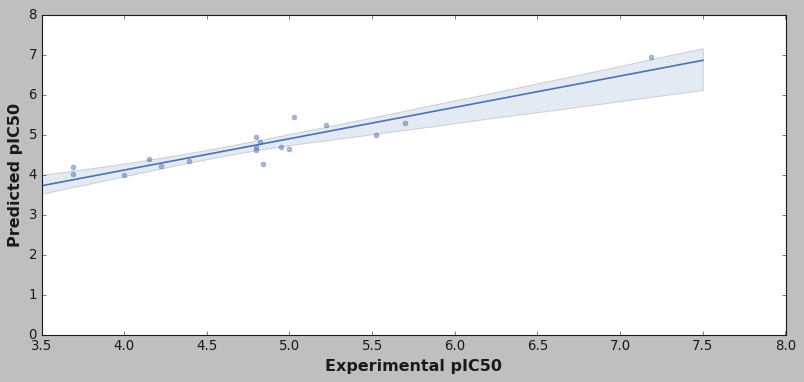

In [287]:
sns.set(color_codes=True)
sns.set_style("white")
plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
plt.figure(figsize=(7, 7))

ax = sns.regplot(x=Y_test, y=Y_pred, scatter_kws={'alpha':0.5},truncate=False, order=1)
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(3.5, 8)
ax.set_ylim(0, 8)
ax.figure.set_size_inches(12, 5)
plt.show

plt.savefig('Random_forest_model.svg')

In [288]:
df = data_cleaned

In [289]:
X = df.drop('pIC50', axis=1)
Y = df.pIC50

# Lets preprocess the data

In [290]:
# Examine X dimension
X.shape

(86, 881)

In [291]:
# Remove low variance features
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X.shape

(86, 185)

In [292]:
# Perform data splitting using 80/20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [293]:
# Defines and builds the lazyclassifier
clf = LazyRegressor(verbose=1,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

 10%|▉         | 4/42 [00:00<00:01, 20.52it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.876381055052708, 'Adjusted R-Squared': 1.0701904178938013, 'RMSE': 0.330507617787484, 'Time taken': 0.1038515567779541}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8754030826752872, 'Adjusted R-Squared': 1.0707457072945403, 'RMSE': 0.33181239578629207, 'Time taken': 0.039397239685058594}
{'Model': 'BayesianRidge', 'R-Squared': 0.79141667842019, 'Adjusted R-Squared': 1.118432902930909, 'RMSE': 0.42931765358632334, 'Time taken': 0.03385162353515625}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9836997528364304, 'Adjusted R-Squared': 1.0092552250843996, 'RMSE': 0.12001514451200117, 'Time taken': 0.03291583061218262}
{'Model': 'DummyRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': 1.5677966101694916, 'RMSE': 0.9400240340008824, 'Time taken': 0.030663728713989258}
{'Model': 'ElasticNet', 'R-Squared': 0.0, 'Adjusted R-Squared': 1.5677966101694916, 'RMSE': 0.9400240340008824, 'Time taken': 0.03258180618286133}


 17%|█▋        | 7/42 [00:08<00:55,  1.59s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7565399968536117, 'Adjusted R-Squared': 1.138235764498373, 'RMSE': 0.463823521825369, 'Time taken': 8.684093475341797}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9836997528364304, 'Adjusted R-Squared': 1.0092552250843996, 'RMSE': 0.12001514451200117, 'Time taken': 0.03336644172668457}


 26%|██▌       | 11/42 [00:09<00:23,  1.30it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9836997528364304, 'Adjusted R-Squared': 1.0092552250843996, 'RMSE': 0.12001514451200115, 'Time taken': 0.2909984588623047}
{'Model': 'GammaRegressor', 'R-Squared': 0.7992729900776405, 'Adjusted R-Squared': 1.1139721158033735, 'RMSE': 0.42115490703164615, 'Time taken': 0.06250905990600586}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.983699752836385, 'Adjusted R-Squared': 1.0092552250844256, 'RMSE': 0.12001514451216827, 'Time taken': 0.09087634086608887}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.97128374097461, 'Adjusted R-Squared': 1.0163049945313656, 'RMSE': 0.15929527301404844, 'Time taken': 0.16614723205566406}


 33%|███▎      | 14/42 [00:10<00:15,  1.76it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7507138181902054, 'Adjusted R-Squared': 1.1415438489936969, 'RMSE': 0.4693405310842438, 'Time taken': 0.7610194683074951}
{'Model': 'HuberRegressor', 'R-Squared': 0.9511949922209926, 'Adjusted R-Squared': 1.027711317976216, 'RMSE': 0.20766875090723297, 'Time taken': 0.10192346572875977}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7073926230752422, 'Adjusted R-Squared': 1.1661414767284641, 'RMSE': 0.5084890358390548, 'Time taken': 0.03110527992248535}
{'Model': 'KernelRidge', 'R-Squared': -24.429833413027133, 'Adjusted R-Squared': 15.438973209091678, 'RMSE': 4.740353345272968, 'Time taken': 0.0338292121887207}


 40%|████      | 17/42 [00:10<00:08,  2.86it/s]

{'Model': 'Lars', 'R-Squared': -3.966321325149211e+85, 'Adjusted R-Squared': 2.2520638032626876e+85, 'RMSE': 5.920152649336798e+42, 'Time taken': 0.1516876220703125}


 45%|████▌     | 19/42 [00:11<00:07,  2.97it/s]

{'Model': 'LarsCV', 'R-Squared': 0.40372278055971733, 'Adjusted R-Squared': 1.3385641839194826, 'RMSE': 0.7258770512869471, 'Time taken': 0.5808565616607666}
{'Model': 'Lasso', 'R-Squared': 0.0, 'Adjusted R-Squared': 1.5677966101694916, 'RMSE': 0.9400240340008824, 'Time taken': 0.03189444541931152}


 52%|█████▏    | 22/42 [00:18<00:21,  1.06s/it]

{'Model': 'LassoCV', 'R-Squared': 0.7636996845824674, 'Adjusted R-Squared': 1.1341705180760566, 'RMSE': 0.45695255313256156, 'Time taken': 7.2217583656311035}
{'Model': 'LassoLars', 'R-Squared': 0.0, 'Adjusted R-Squared': 1.5677966101694916, 'RMSE': 0.9400240340008824, 'Time taken': 0.030763626098632812}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6923936259360611, 'Adjusted R-Squared': 1.1746578564600332, 'RMSE': 0.5213586972161177, 'Time taken': 0.13431477546691895}


 60%|█████▉    | 25/42 [00:18<00:10,  1.56it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.9836992933422907, 'Adjusted R-Squared': 1.0092554859836147, 'RMSE': 0.12001683607736206, 'Time taken': 0.035292625427246094}
{'Model': 'LinearSVR', 'R-Squared': 0.9793698019597289, 'Adjusted R-Squared': 1.0117137565143912, 'RMSE': 0.13501768459558286, 'Time taken': 0.10523104667663574}


 71%|███████▏  | 30/42 [00:19<00:03,  3.02it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9635923184368974, 'Adjusted R-Squared': 1.02067215817566, 'RMSE': 0.1793640780424532, 'Time taken': 0.29489827156066895}
{'Model': 'NuSVR', 'R-Squared': 0.8166636517022156, 'Adjusted R-Squared': 1.1040977570843353, 'RMSE': 0.40249755442365387, 'Time taken': 0.03412675857543945}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8689565351551073, 'Adjusted R-Squared': 1.074406035123795, 'RMSE': 0.34028800547520294, 'Time taken': 0.034696340560913086}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7373637530470233, 'Adjusted R-Squared': 1.1491239707275376, 'RMSE': 0.48174397234938476, 'Time taken': 0.05430269241333008}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9234288710296542, 'Adjusted R-Squared': 1.0434768274662134, 'RMSE': 0.2601186448263952, 'Time taken': 0.0357818603515625}


 76%|███████▌  | 32/42 [00:19<00:02,  3.72it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.8847126691928676, 'Adjusted R-Squared': 1.0654597556277785, 'RMSE': 0.31917564866621545, 'Time taken': 0.04936575889587402}
{'Model': 'QuantileRegressor', 'R-Squared': -0.0012172990333603195, 'Adjusted R-Squared': 1.5684877884341961, 'RMSE': 0.9405960051627993, 'Time taken': 0.13928580284118652}


 90%|█████████ | 38/42 [00:19<00:00,  6.85it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9114755601152493, 'Adjusted R-Squared': 1.0502638768837145, 'RMSE': 0.27968588633439656, 'Time taken': 0.2741727828979492}
{'Model': 'Ridge', 'R-Squared': 0.9675314997639436, 'Adjusted R-Squared': 1.0184355043713202, 'RMSE': 0.16938309798059947, 'Time taken': 0.020497798919677734}
{'Model': 'RidgeCV', 'R-Squared': 0.8973214327413338, 'Adjusted R-Squared': 1.0583005424265308, 'RMSE': 0.3012165691149925, 'Time taken': 0.03578066825866699}
{'Model': 'SGDRegressor', 'R-Squared': 0.8972948668970341, 'Adjusted R-Squared': 1.0583156264228706, 'RMSE': 0.30125553321025433, 'Time taken': 0.03472709655761719}
{'Model': 'SVR', 'R-Squared': 0.8176690037718866, 'Adjusted R-Squared': 1.1035269215871493, 'RMSE': 0.40139245982196897, 'Time taken': 0.03386998176574707}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9836992933422907, 'Adjusted R-Squared': 1.0092554859836147, 'RMSE': 0.12001683607736206, 'Time taken': 0.035826921463012695}
{'Model'

100%|██████████| 42/42 [00:20<00:00,  2.03it/s]


{'Model': 'XGBRegressor', 'R-Squared': 0.9836972229474416, 'Adjusted R-Squared': 1.0092566615467917, 'RMSE': 0.1200244576595071, 'Time taken': 0.5253899097442627}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7507138202294921, 'Adjusted R-Squared': 1.1415438478357969, 'RMSE': 0.4693405291645226, 'Time taken': 0.12427234649658203}
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 10%|▉         | 4/42 [00:00<00:01, 20.21it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.41819031809019636, 'Adjusted R-Squared': 1.0588735987646825, 'RMSE': 0.7272665968773042, 'Time taken': 0.1108555793762207}
{'Model': 'BaggingRegressor', 'R-Squared': 0.3814155060488592, 'Adjusted R-Squared': 1.0625948595069608, 'RMSE': 0.7498988432081608, 'Time taken': 0.039076805114746094}
{'Model': 'BayesianRidge', 'R-Squared': 0.21621501208391714, 'Adjusted R-Squared': 1.079311576158175, 'RMSE': 0.844115042204592, 'Time taken': 0.029772520065307617}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.4964084844409422, 'Adjusted R-Squared': 1.1514222871160478, 'RMSE': 1.1663482711288984, 'Time taken': 0.0351719856262207}
{'Model': 'DummyRegressor', 'R-Squared': -0.3091018252878077, 'Adjusted R-Squared': 1.1324686370826949, 'RMSE': 1.0909124124009797, 'Time taken': 0.032975196838378906}
{'Model': 'ElasticNet', 'R-Squared': -0.3091018252878077, 'Adjusted R-Squared': 1.1324686370826949, 'RMSE': 1.0909124124009797, 'Time taken': 0.031329154968

 17%|█▋        | 7/42 [00:09<00:55,  1.60s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.21000508047473443, 'Adjusted R-Squared': 1.0799399620948185, 'RMSE': 0.8474524081915659, 'Time taken': 8.731047868728638}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.3116066705924283, 'Adjusted R-Squared': 1.1327221035718529, 'RMSE': 1.0919555936500394, 'Time taken': 0.03312873840332031}


 21%|██▏       | 9/42 [00:09<00:36,  1.11s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.23000711677175012, 'Adjusted R-Squared': 1.124465005863808, 'RMSE': 1.0574430352496342, 'Time taken': 0.26332950592041016}
{'Model': 'GammaRegressor', 'R-Squared': 0.22705738476322923, 'Adjusted R-Squared': 1.0782144313037207, 'RMSE': 0.8382562401863258, 'Time taken': 0.027977943420410156}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -28.864183131343644, 'Adjusted R-Squared': 4.021970912100249, 'RMSE': 5.2104890676831275, 'Time taken': 0.03539419174194336}


 29%|██▊       | 12/42 [00:09<00:20,  1.49it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.21409916843417187, 'Adjusted R-Squared': 1.0795256793846373, 'RMSE': 0.845253627248369, 'Time taken': 0.14669108390808105}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.19558217712706483, 'Adjusted R-Squared': 1.0813994225526185, 'RMSE': 0.8551533692695814, 'Time taken': 0.12571263313293457}


 33%|███▎      | 14/42 [00:09<00:14,  1.95it/s]

{'Model': 'HuberRegressor', 'R-Squared': -0.15118481940566553, 'Adjusted R-Squared': 1.1164889400589066, 'RMSE': 1.0230001466316267, 'Time taken': 0.0963895320892334}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.46352804805367465, 'Adjusted R-Squared': 1.054285852280283, 'RMSE': 0.6983556955403167, 'Time taken': 0.0310976505279541}
{'Model': 'KernelRidge', 'R-Squared': -21.889057094282567, 'Adjusted R-Squared': 3.31615458692145, 'RMSE': 4.5615991622955425, 'Time taken': 0.030625343322753906}


 40%|████      | 17/42 [00:09<00:08,  2.91it/s]

{'Model': 'Lars', 'R-Squared': -3.1019235203623537e+111, 'Adjusted R-Squared': 3.138851181319048e+110, 'RMSE': 5.310295782814446e+55, 'Time taken': 0.14274954795837402}


 45%|████▌     | 19/42 [00:10<00:07,  3.02it/s]

{'Model': 'LarsCV', 'R-Squared': 0.005332666429050725, 'Adjusted R-Squared': 1.1006508611351555, 'RMSE': 0.950915872502155, 'Time taken': 0.560187816619873}
{'Model': 'Lasso', 'R-Squared': -0.3091018252878077, 'Adjusted R-Squared': 1.1324686370826949, 'RMSE': 1.0909124124009797, 'Time taken': 0.03230142593383789}


 52%|█████▏    | 22/42 [00:18<00:20,  1.04s/it]

{'Model': 'LassoCV', 'R-Squared': 0.13823032894022047, 'Adjusted R-Squared': 1.0872028833810492, 'RMSE': 0.8851131066160893, 'Time taken': 7.470516920089722}
{'Model': 'LassoLars', 'R-Squared': -0.3091018252878077, 'Adjusted R-Squared': 1.1324686370826949, 'RMSE': 1.0909124124009797, 'Time taken': 0.031179428100585938}
{'Model': 'LassoLarsCV', 'R-Squared': 0.14610582478104328, 'Adjusted R-Squared': 1.08640595820668, 'RMSE': 0.8810594111263402, 'Time taken': 0.1405930519104004}


 60%|█████▉    | 25/42 [00:18<00:10,  1.55it/s]

{'Model': 'LinearRegression', 'R-Squared': -1.6744533053933256e+22, 'Adjusted R-Squared': 1.6943872733146747e+21, 'RMSE': 123378557846.5514, 'Time taken': 0.03445267677307129}
{'Model': 'LinearSVR', 'R-Squared': -0.9174545871262685, 'Adjusted R-Squared': 1.19402814274492, 'RMSE': 1.3202789905356742, 'Time taken': 0.10547256469726562}


 71%|███████▏  | 30/42 [00:18<00:04,  2.98it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.8451895789706645, 'Adjusted R-Squared': 1.1867156121577458, 'RMSE': 1.2951607231000883, 'Time taken': 0.27501964569091797}
{'Model': 'NuSVR', 'R-Squared': 0.5408460520409579, 'Adjusted R-Squared': 1.0464620066387127, 'RMSE': 0.6460740987403797, 'Time taken': 0.03298664093017578}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -1.7957294614398136, 'Adjusted R-Squared': 1.2829011955028382, 'RMSE': 1.5942291305937062, 'Time taken': 0.032758474349975586}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.46159244324559445, 'Adjusted R-Squared': 1.1478992353284232, 'RMSE': 1.152700053881157, 'Time taken': 0.053720951080322266}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.04424177869549162, 'Adjusted R-Squared': 1.1056673228441867, 'RMSE': 0.9743246751418786, 'Time taken': 0.035066843032836914}


 76%|███████▌  | 32/42 [00:19<00:02,  3.66it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.025907924537271754, 'Adjusted R-Squared': 1.0985688409694427, 'RMSE': 0.9410293611526724, 'Time taken': 0.0473020076751709}
{'Model': 'QuantileRegressor', 'R-Squared': -0.3485336248437354, 'Adjusted R-Squared': 1.1364587596568065, 'RMSE': 1.1072203490741657, 'Time taken': 0.14049935340881348}


 90%|█████████ | 38/42 [00:19<00:00,  6.78it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.4158034729599862, 'Adjusted R-Squared': 1.0591151247600015, 'RMSE': 0.7287568574374063, 'Time taken': 0.26796507835388184}
{'Model': 'Ridge', 'R-Squared': -0.26880787268761974, 'Adjusted R-Squared': 1.1283912728314853, 'RMSE': 1.073992135876852, 'Time taken': 0.02128744125366211}
{'Model': 'RidgeCV', 'R-Squared': 0.05525868992972616, 'Adjusted R-Squared': 1.0955988230428253, 'RMSE': 0.9267436563452112, 'Time taken': 0.034535884857177734}
{'Model': 'SGDRegressor', 'R-Squared': 0.08440419191007575, 'Adjusted R-Squared': 1.0926495758186232, 'RMSE': 0.9123365351025663, 'Time taken': 0.03518271446228027}
{'Model': 'SVR', 'R-Squared': 0.5129750262283832, 'Adjusted R-Squared': 1.0492822890126041, 'RMSE': 0.6653938534916446, 'Time taken': 0.03168892860412598}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -1.6744533053933256e+22, 'Adjusted R-Squared': 1.6943872733146747e+21, 'RMSE': 123378557846.5514, 'Time taken': 0.03445887565612793}
{'

100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.02222736828701044, 'Adjusted R-Squared': 1.1034396741719, 'RMSE': 0.9639997496032255, 'Time taken': 0.5076539516448975}
{'Model': 'LGBMRegressor', 'R-Squared': 0.19558216630031622, 'Adjusted R-Squared': 1.0813994236481823, 'RMSE': 0.8551533750243834, 'Time taken': 0.0885167121887207}


In [294]:
# Performance table of the training set (80% subset)
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,22520638032626876291588380050105521054497093390...,-3966321325149210759938106172800993188444019218...,5920152649336797639369067661220678383697920.00,0.15
KernelRidge,15.44,-24.43,4.74,0.03
QuantileRegressor,1.57,-0.00,0.94,0.14
LassoLars,1.57,0.00,0.94,0.03
DummyRegressor,1.57,0.00,0.94,0.03
ElasticNet,1.57,0.00,0.94,0.03
Lasso,1.57,0.00,0.94,0.03
LarsCV,1.34,0.40,0.73,0.58
LassoLarsCV,1.17,0.69,0.52,0.13


In [295]:
predictions_train.to_csv('lazy_prediction_train.csv', index=False)

In [296]:
# Performance table of the test set (20% subset)
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,31388511813190483015391697867981685218488888044...,-3101923520362353678461857081097898374386599117...,53102957828144461214744401850314316534745207689...,0.14
LinearRegression,1694387273314674671616.00,-16744533053933256441856.00,123378557846.55,0.03
TransformedTargetRegressor,1694387273314674671616.00,-16744533053933256441856.00,123378557846.55,0.03
GaussianProcessRegressor,4.02,-28.86,5.21,0.04
KernelRidge,3.32,-21.89,4.56,0.03
OrthogonalMatchingPursuit,1.28,-1.80,1.59,0.03
LinearSVR,1.19,-0.92,1.32,0.11
MLPRegressor,1.19,-0.85,1.30,0.28
DecisionTreeRegressor,1.15,-0.50,1.17,0.04


In [297]:
predictions_test.to_csv('lazy_prediction_test.csv', index=False)

In [ ]:
# Data visualization of model performance

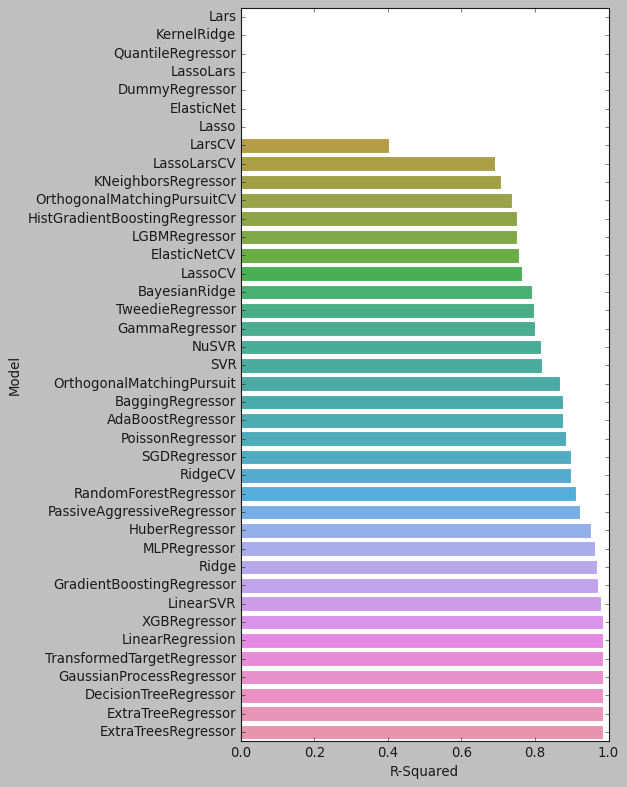

In [301]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
fig, ax = plt.subplots(figsize=(8, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

# Adjust plot margins
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.95)

# Automatically adjust plot margins
plt.tight_layout()

plt.savefig('R2_model_comparism.svg')

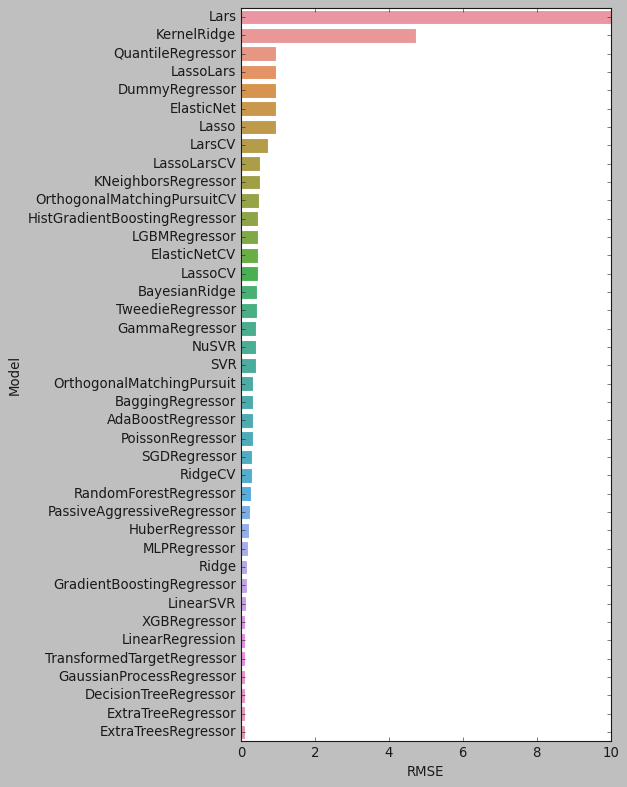

In [307]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
fig, ax = plt.subplots(figsize=(8, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

# Adjust plot margins
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.95)

# Automatically adjust plot margins
plt.tight_layout()

plt.savefig('RMSE_model_comparism.svg')

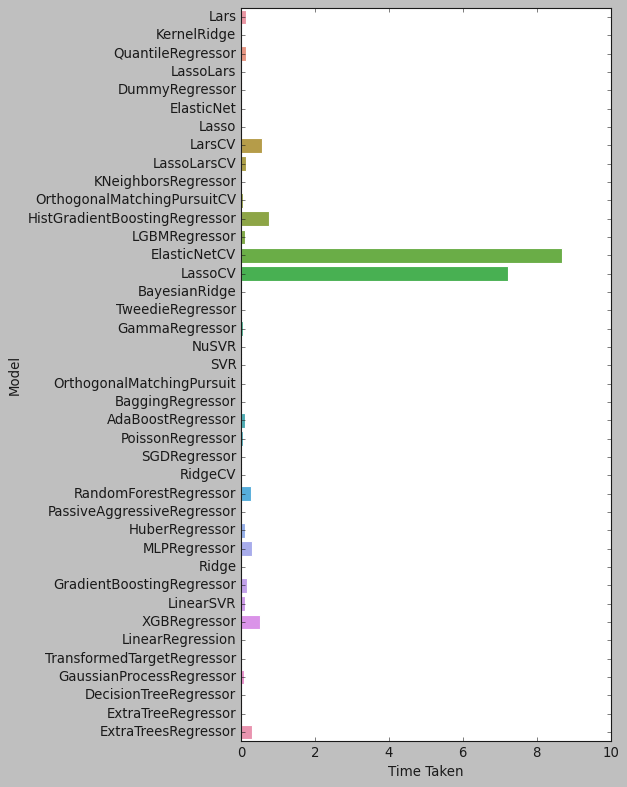

In [309]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
fig, ax = plt.subplots(figsize=(8, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))

# Adjust plot margins
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.95)

# Automatically adjust plot margins
plt.tight_layout()

plt.savefig('time_of_calculation.svg')

In [310]:
! ls

2-raw_data.csv				  mannwhitneyu_LogP.csv
3-raw_data.csv				  mannwhitneyu_MW.csv
4-processed_data.csv			  mannwhitneyu_NumHAcceptors.csv
5-processed_data.csv			  mannwhitneyu_NumHDonors.csv
6-described_data.csv			  mannwhitneyu_pIC50.csv
PaDEL-Descriptor			  molecule.smi
R2_model_comparism.svg			  padel.sh
RMSE_model_comparism.svg		  padel.zip
Random_forest_model.svg			  plot_LogP.svg
__MACOSX				  plot_MW.svg
__notebook_source__.ipynb		  plot_MW_vs_LogP.svg
chloroquine_protein_data_from_ChEMBL.csv  plot_NumHAcceptors.svg
dataframe_for_selected_protein.csv	  plot_NumHDonors.svg
descriptors_output.csv			  plot_bioactivity_class.svg
lazy_prediction_test.csv		  plot_ic50.svg
lazy_prediction_train.csv		  time_of_calculation.svg


In [412]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'Corona_virus_directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [413]:
zip_dir()

/kaggle/working/Corona_virus_directory.zip

# Hyper-parameter tuning

In [349]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [350]:
# Load the data
df = pd.read_csv('6-described_data.csv')

In [352]:
# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10]
}

In [353]:
# Create the Random Forest regressor object
rf = RandomForestRegressor()

In [354]:
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [355]:
# Fit the model to the data
grid_search.fit(df.drop('pIC50', axis=1), df['pIC50'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [10, 50, 100, 200]})

In [356]:
# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': 2, 'n_estimators': 100}


In [357]:
# print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 2, 'n_estimators': 100}
Best score:  -0.4405181816280921


In [358]:
# Get the results of the grid search
results = grid_search.cv_results_

<Figure size 800x440 with 0 Axes>

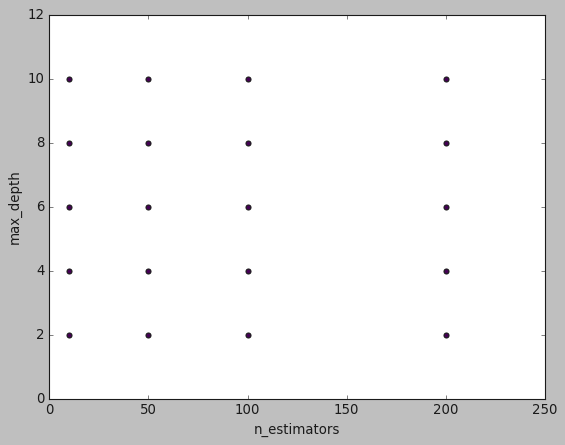

In [410]:
# Plot the 2D graph
plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
plt.figure(figsize=(10, 5.5))

fig, ax = plt.subplots()
for n_estimators, max_depth, score in zip(
    results['param_n_estimators'],
    results['param_max_depth'],
    results['mean_test_score']
):
    ax.scatter(n_estimators, max_depth, c=score, cmap='viridis')
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')

plt.savefig('hyper_tune_2d.svg')

plt.show()

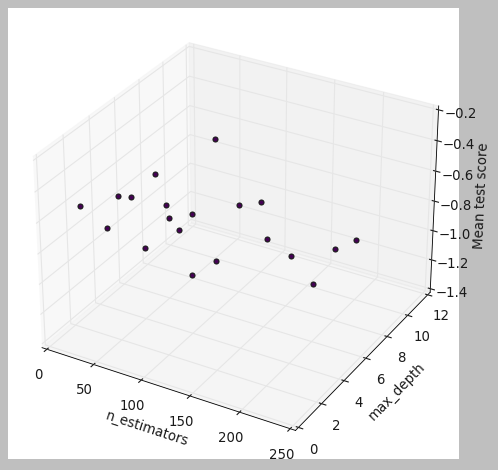

In [376]:
# Plot the 3D graph
# Plot the 2D graph
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

plt.style.use('classic')
plt.rcParams['font.family'] = 'Garamond'
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection='3d')
for n_estimators, max_depth, score in zip(
    results['param_n_estimators'],
    results['param_max_depth'],
    results['mean_test_score']
):
    ax.scatter(n_estimators, max_depth, score, c=score, cmap='viridis')
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('Mean test score')

# Adjust plot margins
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)

# Automatically adjust plot margins
plt.tight_layout()

plt.savefig('hyper_tune_3d.svg')

# Predict New Sets of compounds

In [377]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [389]:
# Load the trained random forest model
model = RandomForestRegressor(n_estimators=100, max_depth=2)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=2)

In [405]:
np.save('X_train.npy', X_train)

In [406]:
np.save('Y_train.npy', Y_train)

Next time you wish to load the saved `npy` files

In [ ]:
np.load(/kaggle/input/data_file/X_train.npy)

In [ ]:
np.load(/kaggle/input/data_file/Y_train.npy)

In [394]:
# Load the new compounds as SMILES strings
new_compounds = ['CC(=O)Nc1ccc(cc1)S(=O)(=O)N', 'CCOC(=O)C1CCN(C(=O)OC(C)(C)C)CC1']

In [395]:
# Generate molecular descriptors and fingerprints using RDKit
mols = [Chem.MolFromSmiles(smi) for smi in new_compounds]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=185) for mol in mols]
descs = np.asarray(fps)

In [396]:
# Preprocess the descriptors
scaler = StandardScaler()
descs_scaled = scaler.fit_transform(descs)

In [397]:
# Make predictions using the trained random forest model
predictions = model.predict(descs_scaled)

In [398]:
# Print the predicted activities of the new compounds
print('Predicted activities:')
for i, activity in enumerate(predictions):
    print(f'Compound {i+1}: {activity}')

Predicted activities:
Compound 1: 5.166472339239731
Compound 2: 4.639699165611624


In [411]:
! ls

2-raw_data.csv				  hyper_tune_3d.svg
3-raw_data.csv				  lazy_prediction_test.csv
4-processed_data.csv			  lazy_prediction_train.csv
5-processed_data.csv			  mannwhitneyu_LogP.csv
6-described_data.csv			  mannwhitneyu_MW.csv
Corona_virus_directory.zip		  mannwhitneyu_NumHAcceptors.csv
PaDEL-Descriptor			  mannwhitneyu_NumHDonors.csv
R2_model_comparism.svg			  mannwhitneyu_pIC50.csv
RMSE_model_comparism.svg		  molecule.smi
Random_forest_model.svg			  padel.sh
X_train.npy				  padel.zip
Y_train.npy				  plot_LogP.svg
__MACOSX				  plot_MW.svg
__notebook_source__.ipynb		  plot_MW_vs_LogP.svg
chloroquine_protein_data_from_ChEMBL.csv  plot_NumHAcceptors.svg
dataframe_for_selected_protein.csv	  plot_NumHDonors.svg
descriptors_output.csv			  plot_bioactivity_class.svg
directory2.zip				  plot_ic50.svg
hyper_tune_2d.svg			  time_of_calculation.svg
